### 1) Imports

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap, Drift
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def get_values_per_slice(particle_coordinates, parts_id):
    value = lambda index: particle_coordinates[index]
    values_per_slice = lambda slice_indices: list(map(value, slice_indices))
    return list(map(values_per_slice, parts_id))

In [4]:
def mean_coordiantes_per_slice(bunch_coord, parts_id):
    coordinate_per_slice = np.array(get_values_per_slice(bunch_coord, parts_id))
    mean_coord = []
    for i in range(len(coordinate_per_slice)):
        mean_temp = np.mean(coordinate_per_slice[i])
        mean_coord.append(mean_temp)
    return mean_coord

In [5]:
plt.close('all')

### 2) Variables we change

In [6]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(1)            #number of cycles to run the simulation for

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = 'file'      #Where the data for the run is saved

wakefieldOn = 1         # Turns on the wakefields

In [7]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================
gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


In [8]:
### Transverse paraamters
### Needed for the createion of the  beam not for the tracking. 
### Heren_segments = 1, no tracking in the longitudinal plane
n_segments = 1
beta_x = 42.0941 * np.ones(n_segments) #### (for Q26)
beta_y = 42.0137 * np.ones(n_segments) #### (for Q26)
alpha_x, alpha_y = 0* np.ones(n_segments), 0* np.ones(n_segments)

In [9]:
# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = [1.9e-3]
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

In [10]:
L = 10000 # [m] length of drift space

In [11]:
one_turn_map = [Drift(alpha, L)] # longitudinal map only

In [12]:
### Create gussian bunch

In [13]:
# CREATE BEAM
# ===========
macroparticlenumber = int(1e5) # at least 5e5 particles are needed in the presence of the wakefields
charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = np.array(alpha)-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
#epsn_z    = 2.5
#sigma_z   = 0.155 #2*0.0755

tau = 1.7e-9 # 4 sigma_t [s]
sigma_z = c*tau/4 #0.155  # m
#sigma_z = 0.#27
#sigma_z = %sigmaz #0.155
print(f'sigma_z= {sigma_z} [m]')


sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

intensity = 3.0e10

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma, alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)

xoffset = 0.0 #0.15*sigma_x #5e-4
yoffset = 0.25*sigma_y #0.5*sigma_y #5e-4
    
bunch.x += xoffset
bunch.y += yoffset
    
afile = open(f'bunch_4_drift_example', 'wb')
pickle.dump(bunch, afile)
afile.close()

sigma_z= 0.12741179465 [m]


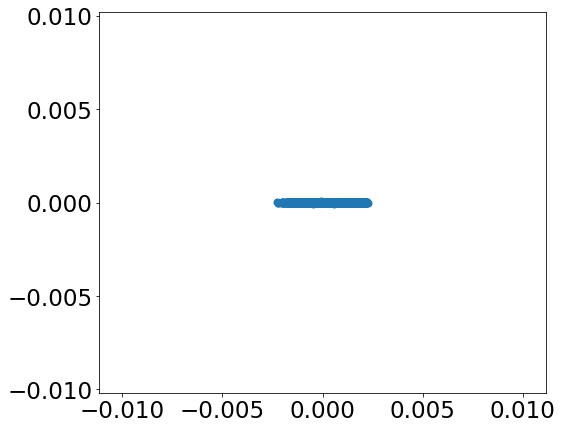

In [14]:
plt.scatter(bunch.y, bunch.yp)

In [15]:
# SLICER FOR WAKEFIELDS
# ============
n_slices = 500 # 500
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)

# WAKEFIELD
# ==========
n_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn
wakefile1=('SPS_complete_wake_model_2018_Q26.txt')
#wakefile1=('SPS_wake_model_with_kicker_wall_2018_Q26.txt')

ww1 = WakeTable(wakefile1, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)

# only dipolar kick
my_length = len(ww1.wake_table['quadrupole_x'])
ww1.wake_table['quadrupole_x'] = np.zeros(my_length)
ww1.wake_table['quadrupole_y'] = np.zeros(my_length)
ww1.wake_table['dipole_x'] = np.zeros(my_length)

#ww1.wake_table['dipole_y'] = ww1.wake_table['dipole_y']*100


wake_field = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)

one_turn_map.append(wake_field)

dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


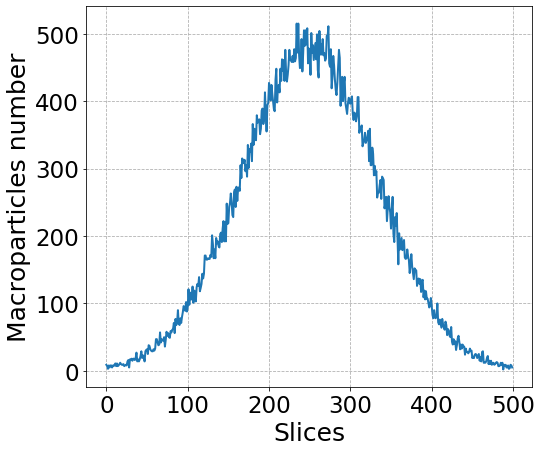

In [16]:
my_sliceSet = bunch.get_slices(slicer_for_wakefields) # type; PyHEADTAIL.particles.slicing.SliceSet


plt.plot(np.arange(my_sliceSet.n_slices), my_sliceSet.n_macroparticles_per_slice, '-')
plt.xlabel('Slices')
plt.ylabel('Macroparticles number')
plt.grid(linestyle='dashed')

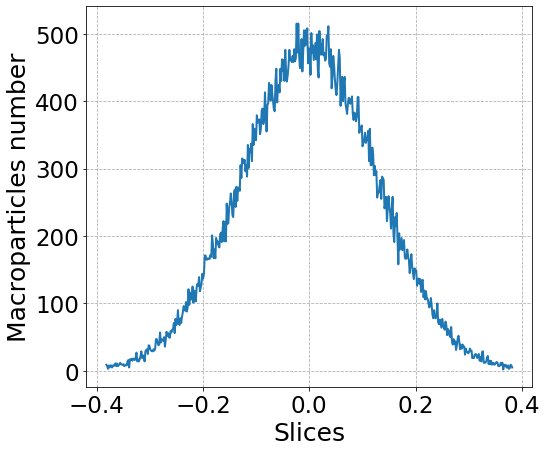

In [17]:
z_centers = my_sliceSet.z_centers

plt.plot(z_centers, my_sliceSet.n_macroparticles_per_slice, '-')
plt.xlabel('Slices')
plt.ylabel('Macroparticles number')
plt.grid(linestyle='dashed')

In [18]:
bunch.particlenumber_per_mp

300000.0

In [19]:
### Plot the wake field

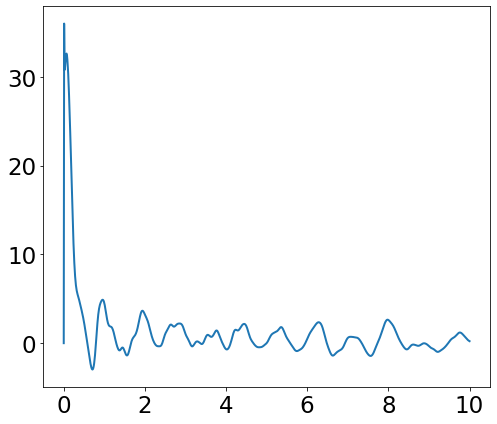

In [20]:
plt.plot(ww1.wake_table['time'], ww1.wake_table['dipole_y'])

In [21]:
# Open bunch file
file2 = open(f'bunch_4_drift_example', 'rb')
bunch = pickle.load(file2)
file2.close()


print(f'Start tracking')
#t0 = time.clock()
for i in range(n_turns):
    for m in one_turn_map:
        m.track(bunch)
        X, XP = bunch.x, bunch.xp
        Y, YP = bunch.y, bunch.yp
        Z, DP = bunch.z, bunch.dp
        


dataExport = [X, XP, Y, YP, Z, DP]

f = open(filename+f'_test_drift.txt', 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: ")# + str(time.clock() - t0))



Start tracking
--> Done.
Simulation time in seconds: 


(-2e-08, 2e-08)

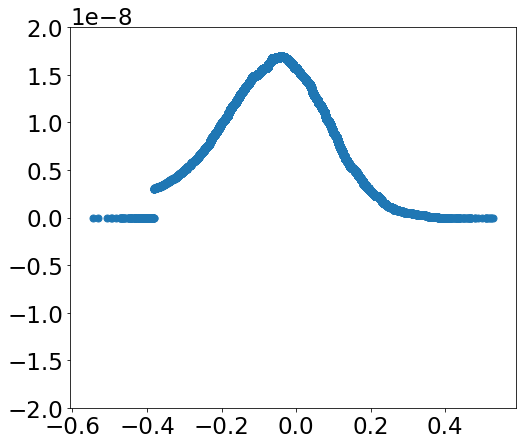

In [22]:
file2 = open(f'bunch_4_drift_example', 'rb')
bunch = pickle.load(file2)
file2.close()

plt.scatter(Z, YP-bunch.yp)


#plt.scatter(bunch.z, bunch.yp)

plt.ylim(-2e-8, 2e-8)


# Open bunch file
#file2 = open(f'bunch_4_drift_example', 'rb')
#bunch_init = pickle.load(file2)
#file2.close()
#plt.scatter(bunch_init.z, bunch_init.yp, marker='.')

### Develop theory part

In [23]:
# A. Convert wake table data to SI
convert_to_s = 1e-9
convert_to_V_per_Cm = 1e15 

time = convert_to_s * ww1.wake_table['time'] # [s]
z_wakes = beta*c*time
wake_strength =  -convert_to_V_per_Cm*ww1.wake_table['dipole_y'] # dz = beta*c*dt, dz<0 for ultrarelativistic 

# The wake(dt) uses the scipy.interpolate.interp1d linear interpolation to calculate the wake strength at an arbitrary
# value of dt (provided it is in the valid range). The valid range of dt is given by the time range from the wake table.


Text(0, 0.5, 'V per Cm')

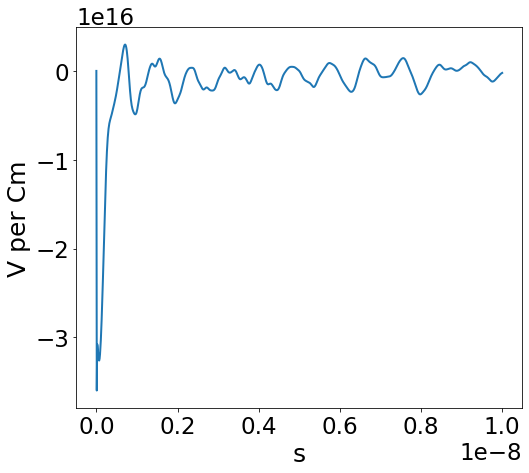

In [24]:
plt.plot(time, wake_strength)
plt.xlabel('s')
plt.ylabel('V per Cm')

In [25]:
## convert z_centers, bunch distribution --> to time

In [26]:
#dt_centers = np.concatenate((my_sliceSet.convert_to_time(z_centers) - 
#                         my_sliceSet.convert_to_time(z_centers[-1]),
#                        (my_sliceSet.convert_to_time(z_centers) -
#                         my_sliceSet.convert_to_time(z_centers[0]))))

dt_centers = my_sliceSet.convert_to_time(z_centers)

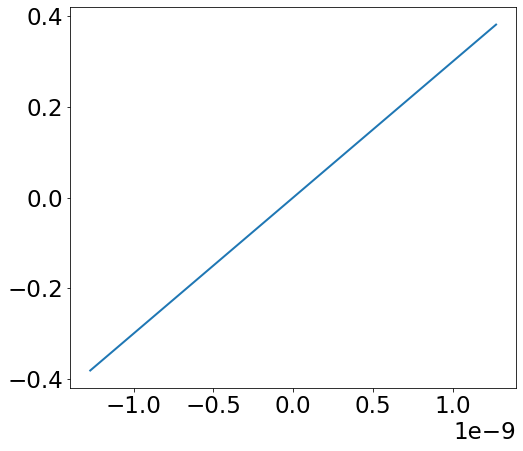

In [27]:
plt.plot(dt_centers, z_centers)

In [28]:
dt_centers = dt_centers.clip(max=0)

In [29]:
# shift them to start 0

In [30]:
dt_centers_offset = [x+np.abs(np.max(dt_centers)) for x in dt_centers]


In [31]:
# interpolate wake strength to any arbitrary value of time. (to check the overlap with the wake)

import scipy as sp

#wake_int = sp.interpolate.interp1d(time, wake_strength)(np.array(dt_centers_offset))
wake_int = sp.interpolate.interp1d(time, wake_strength)(-dt_centers)


In [32]:
time[0]

0.0

In [33]:
wake_strength[1]

-3.598443724081319e+16

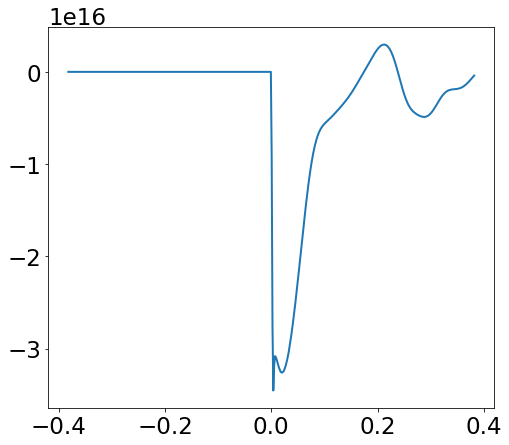

In [34]:
#plt.plot(time, wake_strength)
plt.plot(z_centers, wake_int[::-1])

In [35]:
yy=wake_int[::-1][0]

In [36]:
yy

-0.0

In [37]:
dt_centers_offset[-1]

0.0

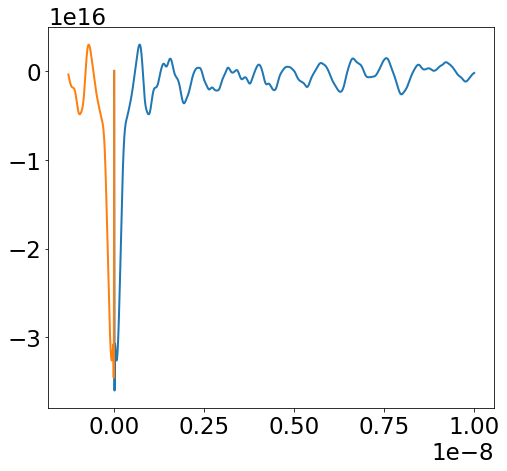

In [38]:
plt.plot(time, wake_strength)
#plt.plot(dt_centers_offset, wake_int)
plt.plot(dt_centers, wake_int)

#plt.plot(time[1:], wake_int_offset)

In [39]:
# create a list with the mean of bunch y for all slices

parts_id = []

my_sliceSet = bunch.get_slices(slicer_for_wakefields) # type; PyHEADTAIL.particles.slicing.SliceSet

for my_slice in np.arange(my_sliceSet.n_slices):
    parts_id.append(my_sliceSet.particle_indices_of_slice(slice_index=my_slice))

# emittance_per_slice(bunch)
mean_y = mean_coordiantes_per_slice(bunch.y, parts_id)
mean_yp = mean_coordiantes_per_slice(bunch.yp, parts_id)


print(len(mean_y))

500


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [40]:
# convolution 

conv_dipole_y = np.convolve(my_sliceSet.n_macroparticles_per_slice*mean_y,  wake_int, 'same')
len(conv_dipole_y)

500

In [41]:
wake_kicks = -charge**2/(mass*gamma*(beta**2)*(c**2))*conv_dipole_y
len(wake_kicks)



500

(-5e-08, 5e-08)

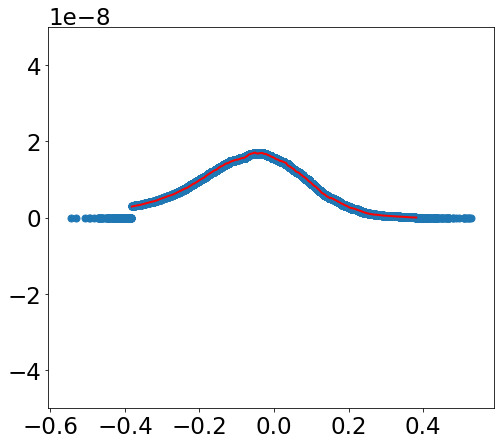

In [42]:
file2 = open(f'bunch_4_drift_example', 'rb')
bunch = pickle.load(file2)
file2.close()

plt.scatter(Z, YP-bunch.yp)

plt.plot(z_centers, 3*wake_kicks*1e5, c='r')
#plt.scatter(bunch.z, bunch.yp)

plt.ylim(-5e-8, 5e-8)


# Open bunch file
#file2 = open(f'bunch_4_drift_example', 'rb')
#bunch_init = pickle.load(file2)
#file2.close()
#plt.scatter(bunch_init.z, bunch_init.yp, marker='.')

Text(0, 0.5, 'V per Cm')

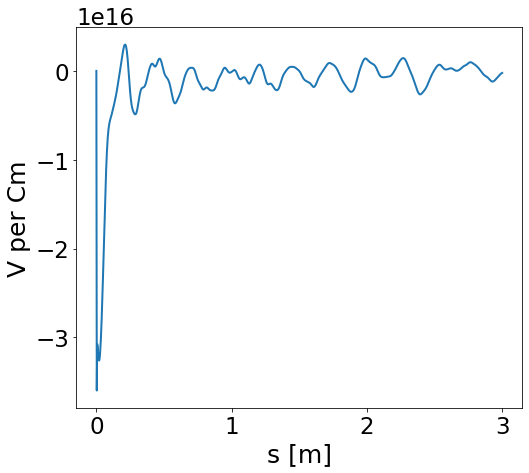

In [95]:
# convert time to z
s_wakes = time*beta*c # [m]
plt.plot(z_wakes, wake_strength)
plt.xlabel('s [m]')
plt.ylabel('V per Cm')
# to 0 dra sto slice 0 --> head

In [113]:
z_centers = my_sliceSet.z_centers
N_slices = np.array(z_centers)
print(len(N_slices))

500


Text(0, 0.5, 'V per Cm')

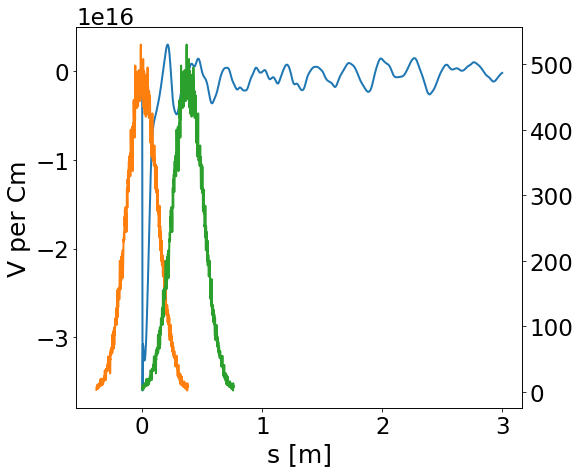

In [114]:
# convert time to z
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()

ax1.plot(z_wakes, wake_strength)
ax2.plot(z_centers, my_sliceSet.n_macroparticles_per_slice, '-', c='C1')

z_centers_offset = [x+np.abs(np.max(z_centers)) for x in z_centers]

ax2.plot(z_centers_offset, my_sliceSet.n_macroparticles_per_slice, '-', c='C2')

ax1.set_xlabel('s [m]')
ax1.set_ylabel('V per Cm')
# to 0 dra sto slice 0 --> head

In [139]:
z_cut_head = my_sliceSet.z_cut_head
z_cut_tail = my_sliceSet.z_cut_tail
print(z_cut_head, z_cut_tail)
z_boundary = 2*z_cut_head

0.38223538395001067 -0.38223538395


In [140]:
# discard all the values of the wake for > bunch length. > 2*np.max(z_centers)
z_wakes_boundaries = [x for x in z_wakes if x <=2*np.max(z_boundary)]
print(len(z_wakes_boundaries))

wake_strength_boundaries = wake_strength[:len(z_wakes_boundaries)]

#print(len(wake_strength))

511


In [144]:
# interpolate to the z of the bunch distribution
wake_interpolated = np.interp(z_centers_offset, z_wakes_boundaries, wake_strength_boundaries)

#wake_interpolated = np.interp(z_centers, z_wakes_boundaries, wake_strength_boundaries)

(0, 1)

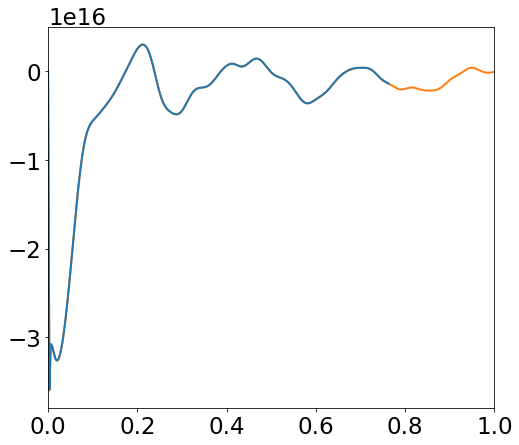

In [145]:

plt.plot(z_wakes, wake_strength, c='C1')
plt.plot(z_centers_offset, wake_interpolated, c='C0')
plt.xlim(0,1)


In [146]:
# create a list with the mean of bunch y for all slices

parts_id = []

my_sliceSet = bunch.get_slices(slicer_for_wakefields) # type; PyHEADTAIL.particles.slicing.SliceSet

for my_slice in np.arange(my_sliceSet.n_slices):
    parts_id.append(my_sliceSet.particle_indices_of_slice(slice_index=my_slice))

# emittance_per_slice(bunch)
mean_y = mean_coordiantes_per_slice(bunch.y, parts_id)
mean_yp = mean_coordiantes_per_slice(bunch.yp, parts_id)


print(len(mean_y))

500


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [147]:
# convolution 

conv_dipole_y = np.convolve(my_sliceSet.n_macroparticles_per_slice*mean_y,  wake_interpolated[::-1], 'same')
len(conv_dipole_y)

500

In [148]:
wake_kicks = -charge**2/(mass*gamma*(beta**2)*(c**2))*conv_dipole_y
len(wake_kicks)



500

(-2e-08, 2e-08)

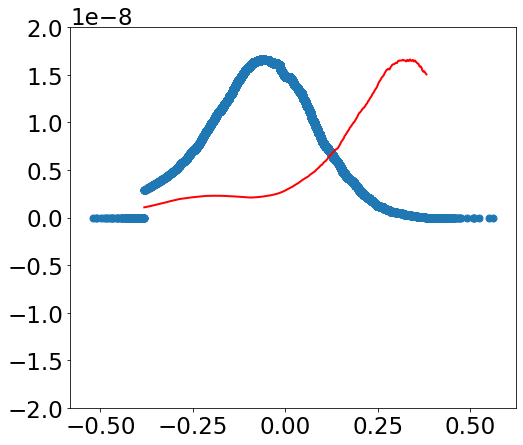

In [149]:
file2 = open(f'bunch_4_drift_example', 'rb')
bunch = pickle.load(file2)
file2.close()

plt.scatter(Z, YP-bunch.yp)

plt.plot(z_centers, 3*wake_kicks*1e5, c='r')
#plt.scatter(bunch.z, bunch.yp)

plt.ylim(-2e-8, 2e-8)


# Open bunch file
#file2 = open(f'bunch_4_drift_example', 'rb')
#bunch_init = pickle.load(file2)
#file2.close()
#plt.scatter(bunch_init.z, bunch_init.yp, marker='.')

In [220]:
z_cut_head = my_sliceSet.z_cut_head
z_cut_tail = my_sliceSet.z_cut_tail
print(z_cut_head, z_cut_tail)
z_boundary = 2*z_cut_head

0.38223538395001067 -0.38223538395


In [221]:
# discard all the values of the wake for > bunch length. > 2*np.max(z_centers)
z_wakes_boundaries = [x for x in z_wakes if x <=2*np.max(z_boundary)]
print(len(z_wakes_boundaries))

511


In [222]:

wake_strength = wake_strength[:len(z_wakes_boundaries)]

print(len(wake_strength))

511


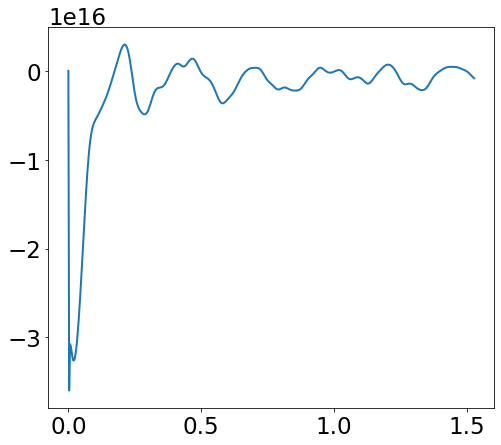

In [223]:
plt.plot(z_wakes_boundaries, wake_strength)

In [40]:
# interpolate to the z of the bunch distribution
wake_interpolated = np.interp(np.abs(z_centers), z_wakes_boundaries, wake_strength)
wake_interpolated = np.interp(z_centers, z_wake, wake_strength)


NameError: name 'z_wakes_boundaries' is not defined

In [41]:
plt.plot(z_centers, wake_interpolated)
#plt.plot(z_wakes, wake_strength)

NameError: name 'wake_interpolated' is not defined

In [174]:
len(my_sliceSet.n_macroparticles_per_slice)

500

In [175]:
# create a list with the mean of bunch y for all slices

parts_id = []

my_sliceSet = bunch.get_slices(slicer_for_wakefields) # type; PyHEADTAIL.particles.slicing.SliceSet

for my_slice in np.arange(my_sliceSet.n_slices):
    parts_id.append(my_sliceSet.particle_indices_of_slice(slice_index=my_slice))

# emittance_per_slice(bunch)
mean_y = mean_coordiantes_per_slice(bunch.y, parts_id)
mean_yp = mean_coordiantes_per_slice(bunch.yp, parts_id)


print(len(meany))

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


500


In [177]:
# convolution 

conv_dipole_y = np.convolve(my_sliceSet.n_macroparticles_per_slice*mean_y,  wake_interpolated[::-1], 'same')
len(conv_dipole_y)

500

In [195]:
wake_kicks = -charge**2/(mass*gamma*(beta**2)*(c**2))*conv_dipole_y
len(wake_kicks)

500

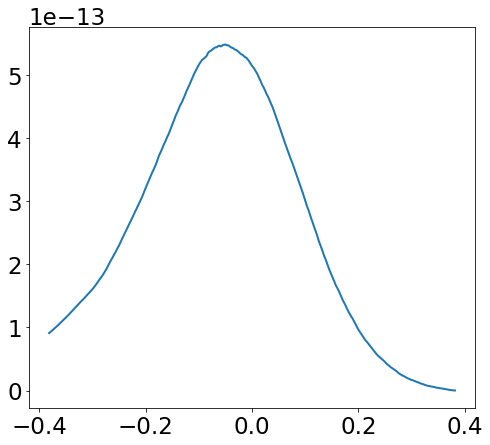

In [196]:
plt.plot(z_centers, wake_kicks)

(-2e-07, 2e-07)

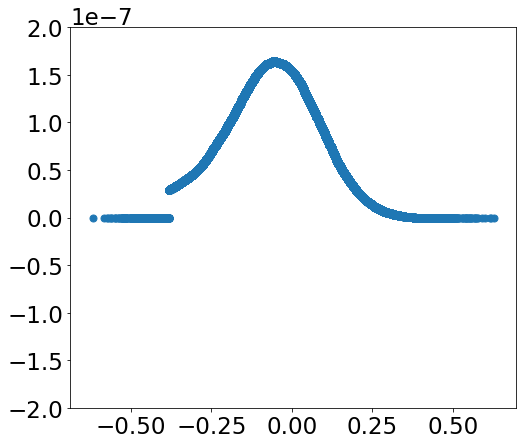

In [190]:
file2 = open(f'bunch_4_drift_example', 'rb')
bunch = pickle.load(file2)
file2.close()

plt.scatter(Z, YP-bunch.yp)

plt.plot(z_centers, 3*wake_kicks*1e5, c='r')
#plt.scatter(bunch.z, bunch.yp)

plt.ylim(-2e-7, 2e-7)


# Open bunch file
#file2 = open(f'bunch_4_drift_example', 'rb')
#bunch_init = pickle.load(file2)
#file2.close()
#plt.scatter(bunch_init.z, bunch_init.yp, marker='.')